In [1]:
import pandas as pd
import numpy as np
import itertools
import re
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Data import CodonTable
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import math
import gzip
import os

# APOBEC mutagenesis in MPXV
## Table of contents <a name="TOC"></a>
1. [Downloading data](#dwnl)
2. [Plots with mutations by allele for VCF files](#vcf_allele_plots)
3. [Comparison C>T mutations by motifs with other types of mutations](#compare)
4. [Simulation](#simulation)
    1. [Visualization of shares of real and simulated positions with mutations from potential ones](#shares)
    2. [Visualization of real and simulated number of reads for targets positions by replica and time](#sim_Nreads)
    3. [Get positions with the greatest and the least number of reads in real sample](#greatest_pos)

## Downloading Oxford Nanopore long-read RNA-seq data from project PRJEB56841
source - DOI: 10.1038/s41597-023-02149-4

only dRNA samples

<a name='dwnl'></a>
[Return to Table of Contents](#TOC)

## Plots with mutations by allele for VCF files 

<a name='vcf_allele_plots'></a>
[Return to Table of Contents](#TOC)

In [2]:
fig_list = ['Nreads', 'freq']
align_method = 'minimap2'

##min variant frequency
min_VF = 0.001

##genome file
genome_file = open("data/NC_063383.1.fasta")
genome_dict = SeqIO.to_dict(SeqIO.parse(genome_file, "fasta"))

##palette for pictures
colors_list = ['#C6878F', '#3D405B', '#81B29A', '#E07A5F', '#5F797B', '#F2CC8F']

In [3]:
#function to rounding up top position
def round_up(n, decimals=0):
    multiplier = 10**decimals
    return math.ceil(n * multiplier) / multiplier

def get_plot_vcf(vcf_file, ID, method=align_method, min_vf=min_VF, genome=str(genome_dict['NC_063383.1'].seq), colors=colors_list):
    
    ##read vcf file
    ##skip description in vcf file
    with open(vcf_file, 'r') as f:
        reader=f.readlines()
        row = 0
        while reader[row].startswith('##') == True:
            row += 1
    df_vcf = pd.read_csv(vcf_file, skiprows=row, sep='\t')
    df_vcf = df_vcf.dropna()
    
    ##make dataframe from vcf file
    ###list with all allele variants of 3 nucleotides
    A = ['A'.join(i) for i in itertools.product('ATCG', repeat=2)]
    T = ['T'.join(i) for i in itertools.product('ATCG', repeat=2)]
    C = ['C'.join(i) for i in itertools.product('ATCG', repeat=2)]
    G = ['G'.join(i) for i in itertools.product('ATCG', repeat=2)]
    allele_list = A + T + C + G

    ###dataframe for counting reads number for mutations
    df_Nreads = pd.DataFrame(columns=['ref_nucl', 'allele', 'A', 'T', 'C', 'G'])
    df_Nreads['ref_nucl'] = ['A']*16 + ['T']*16 + ['C']*16 + ['G']*16
    df_Nreads['allele'] = allele_list
    df_Nreads = df_Nreads.set_index('allele')
    df_Nreads.fillna(0, inplace=True)
    ###replace cells with no mutation (like A>A) with NaN
    for nucl in ['A', 'T', 'C', 'G']:
        df_Nreads.loc[df_Nreads['ref_nucl'] == nucl, nucl] = np.nan
    
    ###dataframe for counting allele's frequencies for mutations
    df_freq = pd.DataFrame(columns=['ref_nucl', 'allele', 'A', 'T', 'C', 'G'])
    df_freq['ref_nucl'] = ['A']*16 + ['T']*16 + ['C']*16 + ['G']*16
    df_freq['allele'] = allele_list
    df_freq = df_freq.set_index('allele')
    df_freq.fillna(0, inplace=True)
    ###replace cells with no mutation (like A>A) with NaN
    for nucl in ['A', 'T', 'C', 'G']:
        df_freq.loc[df_freq['ref_nucl'] == nucl, nucl] = np.nan
        

    for row in range(0, len(df_vcf)):
        mutation_pos = df_vcf.loc[row, 'POS'] - 1
        allele = genome[mutation_pos-1:mutation_pos+2]
        alt_nucl = df_vcf.loc[row, 'ALT']
        if (len(alt_nucl) != 1) or (len(df_vcf.loc[row, 'REF']) != 1) or (len(allele) != 3):
            continue

        ###Allele Depth (AD) in vcf file: first number - number of reads with ref nucl, second - with alt nucl (Nreads_alt)
        FORMAT = df_vcf.iloc[row, -2].split(':')
        AD_ind = FORMAT.index('AD')
        AF_ind = FORMAT.index('AF')
        AD = df_vcf.iloc[row, -1].split(':')[AD_ind]
        Nreads_alt = int(AD.split(',')[1])
        AF = df_vcf.iloc[row, -1].split(':')[AF_ind]
        freq = float(AF)
        if freq >= min_vf:
            df_Nreads.at[allele, alt_nucl] += Nreads_alt
            df_freq.at[allele, alt_nucl] += freq
        
    
    df_Nreads.reset_index(inplace=True)
    df_Nreads = df_Nreads.set_index(['allele'])
    df_Nreads = df_Nreads[['A', 'T', 'C', 'G']].stack()
    df_Nreads = df_Nreads.to_frame().reset_index()
    df_Nreads = df_Nreads.dropna()
    df_Nreads = df_Nreads.rename(columns={"level_1": "ALT", 0:'Nreads'})
    df_Nreads['REF'] = df_Nreads['allele'].apply(lambda x: x[1])
    df_Nreads['mutation'] = df_Nreads['REF'] + '>' + df_Nreads['ALT']
    df_Nreads = df_Nreads[['allele', 'REF', 'ALT', 'mutation', 'Nreads']]
    df_Nreads = df_Nreads.sort_values(by=['mutation', 'allele'])
    df_Nreads = df_Nreads.reset_index(drop=True)
    
    df_freq.reset_index(inplace=True)
    df_freq = df_freq.set_index(['allele'])
    df_freq = df_freq[['A', 'T', 'C', 'G']].stack()
    df_freq = df_freq.to_frame().reset_index()
    df_freq = df_freq.dropna()
    df_freq = df_freq.rename(columns={"level_1": "ALT", 0:'freq'})
    df_freq['REF'] = df_freq['allele'].apply(lambda x: x[1])
    df_freq['mutation'] = df_freq['REF'] + '>' + df_freq['ALT']
    df_freq = df_freq[['allele', 'REF', 'ALT', 'mutation', 'freq']]
    df_freq = df_freq.sort_values(by=['mutation', 'allele'])
    df_freq = df_freq.reset_index(drop=True)

    # picture
    custom_palette = []
    for x in colors:
        custom_palette.extend([x]*16)
    ##divide dataframe into two parts
    df1_Nreads = df_Nreads[df_Nreads['REF'].isin(['A', 'C'])]
    df2_Nreads = df_Nreads[df_Nreads['REF'].isin(['G', 'T'])]
    df1_freq = df_freq[df_freq['REF'].isin(['A', 'C'])]
    df2_freq = df_freq[df_freq['REF'].isin(['G', 'T'])]

    mutation_list1 = df1_Nreads.mutation.to_list()
    mutation_list1 = list(set(mutation_list1))
    mutation_list1.sort()
    mutation_list2 = df2_Nreads.mutation.to_list()
    mutation_list2 = list(set(mutation_list2))
    mutation_list2.sort()

    ###picture for number of reads
    fig1 = plt.figure(figsize=(16, 7))
    ax11 = plt.subplot2grid(shape=(2, 1), loc=(0, 0))
    ax12 = plt.subplot2grid(shape=(2, 1), loc=(1, 0))

    ax11 = sns.barplot(x=df1_Nreads.index, y=df1_Nreads.Nreads, palette=custom_palette, ax=ax11)
    ax12 = sns.barplot(x=df2_Nreads.index, y=df2_Nreads.Nreads, palette=custom_palette, ax=ax12)
    ax11.set_xticklabels(df1_Nreads.allele, rotation=90, horizontalalignment='center')
    ax12.set_xticklabels(df2_Nreads.allele, rotation=90, horizontalalignment='center')

    ####change lim of picture
    top_position = int(df_Nreads.Nreads.max())
    round_pos = 0
    while top_position >= 10:
        top_position = int(top_position / 10)
        round_pos += 1
    new_top_position = round_up(df_Nreads.Nreads.max(), -round_pos)

    ####rectangle must place 10% of space
    part_ten = int(new_top_position/10)
    ax11.set_ylim(0, new_top_position+part_ten)
    ax12.set_ylim(0, new_top_position+part_ten)

    ####add rectangles
    for i in range(0, len(colors)):
        ax11.add_patch(Rectangle((i*16, new_top_position), 16, part_ten, facecolor = colors[i]))
        ax11.text(i*16+8, new_top_position+int(part_ten/2), mutation_list1[i], horizontalalignment='center', verticalalignment='center', size='x-large', color='white', weight='semibold')
        ax12.add_patch(Rectangle((i*16, new_top_position), 16, part_ten, facecolor = colors[i]))
        ax12.text(i*16+8, new_top_position+int(part_ten/2), mutation_list2[i], horizontalalignment='center', verticalalignment='center', size='x-large', color='white', weight='semibold')

    ####save picture
    fig1.suptitle('Number of reads by mutation type for sample '+ID+'\naligned using '+method, fontsize=18)
    plt.tight_layout()
    plt.close(fig1)


    ###picture for freq
    fig2 = plt.figure(figsize=(16, 7))
    ax21 = plt.subplot2grid(shape=(2, 1), loc=(0, 0))
    ax22 = plt.subplot2grid(shape=(2, 1), loc=(1, 0))

    ax21 = sns.barplot(x=df1_freq.index, y=df1_freq.freq, palette=custom_palette, ax=ax21)
    ax22 = sns.barplot(x=df2_freq.index, y=df2_freq.freq, palette=custom_palette, ax=ax22)
    ax21.set_xticklabels(df1_freq.allele, rotation=90, horizontalalignment='center')
    ax22.set_xticklabels(df2_freq.allele, rotation=90, horizontalalignment='center')

    ####change lim of picture
    top_position = df_freq.freq.max()
    if top_position >= 1:
        new_top_position = top_position + 0.1
    else:
        round_pos = 0
        while top_position < 1:
            top_position = top_position * 10
            round_pos += 1
        new_top_position = round_up(df_freq.freq.max(), round_pos)
        

    ####rectangle must place 10% of space
    part_ten = new_top_position/10
    ax21.set_ylim(0, new_top_position+part_ten)
    ax22.set_ylim(0, new_top_position+part_ten)
    

    ####add rectangles
    for i in range(0, len(colors)):
        ax21.add_patch(Rectangle((i*16, new_top_position), 16, part_ten, facecolor = colors[i]))
        ax21.text(i*16+8, new_top_position+part_ten/2, mutation_list1[i], horizontalalignment='center', verticalalignment='center', size='x-large', color='white', weight='semibold')
        ax22.add_patch(Rectangle((i*16, new_top_position), 16, part_ten, facecolor = colors[i]))
        ax22.text(i*16+8, new_top_position+part_ten/2, mutation_list2[i], horizontalalignment='center', verticalalignment='center', size='x-large', color='white', weight='semibold')

    fig2.suptitle('Allele frequency by mutation type for sample '+ID+'\naligned using '+method, fontsize=18)
    plt.tight_layout()
    plt.close(fig2)
    
    return [fig1, fig2]

In [5]:
# path to directory with .vcf files
directory = "data/vcf/"
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if f.endswith(".vcf"):
        sample_id = filename[:-4]
        print(sample_id, end=', ')
        plot_list = get_plot_vcf(f, sample_id)
        for i in range(0, len(plot_list)):
            plot_list[i].savefig(directory+'/pictures/'+sample_id+'_'+fig_list[i]+'.png')

ERR10513574, ERR10963128, 

## Comparison C>T mutations by motifs with other types of mutations

<a name='compare'></a>
[Return to Table of Contents](#TOC)

In [7]:
##mutations categories
category_list = ['TCT', 'TCA', 'TCC', 'TCG', '*']
category_complement_list = ['AGA', 'TGA', 'GGA', 'CGA', '*']

In [9]:
id_samples = ['ERR10513574', 'ERR10963128']
df = pd.DataFrame(index=id_samples)
df['allele'] = ''
df.head()

,allele
ERR10513574,
ERR10963128,


In [11]:
#function to rounding up top position
def round_up(n, decimals=0):
    multiplier = 10**decimals
    return math.ceil(n * multiplier) / multiplier

def Nread_freq_by_category(vcf_file, category = category_list, category_complement = category_complement_list, min_vf=min_VF, genome=str(genome_dict['NC_063383.1'].seq)):
    
    ##read vcf file
    ##skip description in vcf file
    with open(vcf_file, 'r') as f:
        reader=f.readlines()
        row = 0
        while reader[row].startswith('##') == True:
            row += 1
    df_vcf = pd.read_csv(vcf_file, skiprows=row, sep='\t')
    df_vcf = df_vcf.dropna()
    
    ##make dataframe from vcf file
    ###list with all allele variants of 3 nucleotides
    A = ['A'.join(i) for i in itertools.product('ATCG', repeat=2)]
    T = ['T'.join(i) for i in itertools.product('ATCG', repeat=2)]
    C = ['C'.join(i) for i in itertools.product('ATCG', repeat=2)]
    G = ['G'.join(i) for i in itertools.product('ATCG', repeat=2)]
    allele_list = A + T + C + G

    ###dataframe for counting reads number for mutations
    df_Nreads = pd.DataFrame(columns=['ref_nucl', 'allele', 'A', 'T', 'C', 'G'])
    df_Nreads['ref_nucl'] = ['A']*16 + ['T']*16 + ['C']*16 + ['G']*16
    df_Nreads['allele'] = allele_list
    df_Nreads = df_Nreads.set_index('allele')
    df_Nreads.fillna(0, inplace=True)
    ###replace cells with no mutation (like A>A) with NaN
    for nucl in ['A', 'T', 'C', 'G']:
        df_Nreads.loc[df_Nreads['ref_nucl'] == nucl, nucl] = np.nan
    
    ###dataframe for counting allele's frequencies for mutations
    df_freq = pd.DataFrame(columns=['ref_nucl', 'allele', 'A', 'T', 'C', 'G'])
    df_freq['ref_nucl'] = ['A']*16 + ['T']*16 + ['C']*16 + ['G']*16
    df_freq['allele'] = allele_list
    df_freq = df_freq.set_index('allele')
    df_freq.fillna(0, inplace=True)
    ###replace cells with no mutation (like A>A) with NaN
    for nucl in ['A', 'T', 'C', 'G']:
        df_freq.loc[df_freq['ref_nucl'] == nucl, nucl] = np.nan
        

    for row in range(0, len(df_vcf)):
        mutation_pos = df_vcf.loc[row, 'POS'] - 1
        allele = genome[mutation_pos-1:mutation_pos+2]
        alt_nucl = df_vcf.loc[row, 'ALT']
        if (len(alt_nucl) != 1) or (len(df_vcf.loc[row, 'REF']) != 1) or (len(allele) != 3):
            continue

        ###Allele Depth (AD) in vcf file: first number - number of reads with ref nucl, second - with alt nucl (Nreads_alt)
        FORMAT = df_vcf.iloc[row, -2].split(':')
        AD_ind = FORMAT.index('AD')
        AF_ind = FORMAT.index('AF')
        AD = df_vcf.iloc[row, -1].split(':')[AD_ind]
        Nreads_alt = int(AD.split(',')[1])
        AF = df_vcf.iloc[row, -1].split(':')[AF_ind]
        freq = float(AF)
        if freq >= min_vf:
            df_Nreads.at[allele, alt_nucl] += Nreads_alt
            df_freq.at[allele, alt_nucl] += freq
        
    
    df_Nreads.reset_index(inplace=True)
    df_Nreads = df_Nreads.set_index(['allele'])
    df_Nreads = df_Nreads[['A', 'T', 'C', 'G']].stack()
    df_Nreads = df_Nreads.to_frame().reset_index()
    df_Nreads = df_Nreads.dropna()
    df_Nreads = df_Nreads.rename(columns={"level_1": "ALT", 0:'Nreads'})
    df_Nreads['REF'] = df_Nreads['allele'].apply(lambda x: x[1])
    df_Nreads['mutation'] = df_Nreads['REF'] + '>' + df_Nreads['ALT']
    df_Nreads = df_Nreads[['allele', 'REF', 'ALT', 'mutation', 'Nreads']]
    df_Nreads = df_Nreads.sort_values(by=['mutation', 'allele'])
    df_Nreads = df_Nreads.reset_index(drop=True)
    
    #count for category
    Nreads = []
    for i in range(0, len(category[:-1])):
        motif = category[i]
        motif_complement = category_complement[i]
        Nr1 = df_Nreads[(df_Nreads['allele'] == motif) & (df_Nreads['mutation'] == 'C>T')]['Nreads'].sum()
        Nr2 = df_Nreads[(df_Nreads['allele'] == motif_complement) & (df_Nreads['mutation'] == 'G>A')]['Nreads'].sum()
        Nreads.append(Nr1+Nr2)
    Nreads.append(df_Nreads['Nreads'].sum() - sum(Nreads))
    
    df_freq.reset_index(inplace=True)
    df_freq = df_freq.set_index(['allele'])
    df_freq = df_freq[['A', 'T', 'C', 'G']].stack()
    df_freq = df_freq.to_frame().reset_index()
    df_freq = df_freq.dropna()
    df_freq = df_freq.rename(columns={"level_1": "ALT", 0:'freq'})
    df_freq['REF'] = df_freq['allele'].apply(lambda x: x[1])
    df_freq['mutation'] = df_freq['REF'] + '>' + df_freq['ALT']
    df_freq = df_freq[['allele', 'REF', 'ALT', 'mutation', 'freq']]
    df_freq = df_freq.sort_values(by=['mutation', 'allele'])
    df_freq = df_freq.reset_index(drop=True)
    
    #count for category
    freq = []
    for i in range(0, len(category[:-1])):
        motif = category[i]
        motif_complement = category_complement[i]
        freq1 = df_freq[(df_freq['allele'] == motif) & (df_freq['mutation'] == 'C>T')]['freq'].sum()
        freq2 = df_freq[(df_freq['allele'] == motif_complement) & (df_freq['mutation'] == 'G>A')]['freq'].sum()
        freq.append(freq1+freq2)
    freq.append(df_freq['freq'].sum() - sum(freq))
    
    new_list=[]
    for i in range(0, len(category)):
        new_list.append([category[i]]+[Nreads[i]]+[freq[i]])
    
    return new_list

In [17]:
vcf_dir = "data/vcf/"

for sample in id_samples:
    VCF_FILE = os.path.join(vcf_dir, sample+'.vcf')
    df.loc[sample]['allele'] = Nread_freq_by_category(VCF_FILE)

#transform table
transformed_df = df.explode('allele')
df2 = transformed_df.allele.apply(pd.Series)
df2.columns = ['allele', 'Nreads', 'freq']
result = pd.concat([transformed_df[transformed_df.columns[:-1]], df2], axis=1)
result = result.reset_index()
result = result.rename(columns={"index": "sample", "Nreads":"Number of reads", "freq":"Allele frequency"})
result

,sample,allele,Number of reads,Allele frequency
0,ERR10513574,TCT,33955.0,22.7185
1,ERR10513574,TCA,12674.0,15.3694
2,ERR10513574,TCC,1748.0,4.4845
3,ERR10513574,TCG,16226.0,18.6137
4,ERR10513574,*,17564.0,15.0573
5,ERR10963128,TCT,38090.0,23.7635
6,ERR10963128,TCA,12658.0,15.2456
7,ERR10963128,TCC,1755.0,4.5994
8,ERR10963128,TCG,16225.0,18.5879
9,ERR10963128,*,18901.0,16.1445


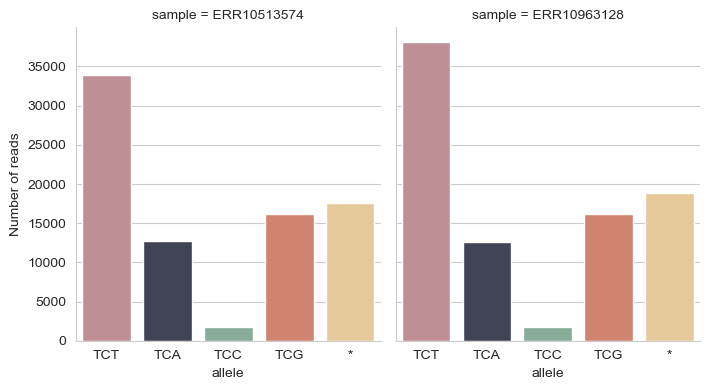

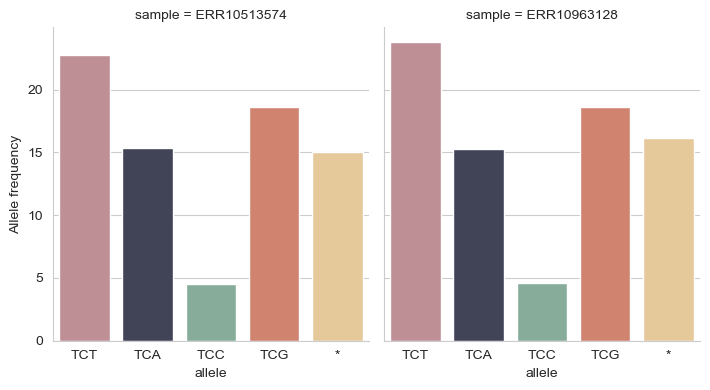

In [21]:
#picture
colors_list = ['#C6878F', '#3D405B', '#81B29A', '#E07A5F', '#F2CC8F']

##Number of reads
outfile = "data/vcf/pictures/Nreads_by_categories.png"
plot = sns.catplot(
    data=result, kind="bar",
    x="allele", y="Number of reads", col="sample", hue="allele",
    height=4, aspect=.9, palette=colors_list, dodge=False
)
sns.set_style("whitegrid")
plot.savefig(outfile, dpi=800)

##Allele frequency
outfile = "data/vcf/pictures/freq_by_categories.png"
plot = sns.catplot(
    data=result, kind="bar",
    x="allele", y="Allele frequency", col="sample", hue="allele",
    height=4, aspect=.9, palette=colors_list, dodge=False
)
sns.set_style("whitegrid")
plot.savefig(outfile, dpi=800)

Filter only APOBEC mutations

In [8]:
def filter_APOBEC_mutations(vcf_file, outfile, genome=str(genome_dict['NC_063383.1'].seq)):
    
    ##read vcf file
    ##skip description in vcf file
    with open(vcf_file, 'r') as fin, open(outfile, 'w') as fout:
        reader=fin.readlines()
        row = 0
        while reader[row].startswith('##') == True:
            fout.write(reader[row])
            row += 1

    df_vcf = pd.read_csv(vcf_file, skiprows=row, sep='\t')
    df_vcf = df_vcf.dropna()
    df1 = df_vcf[(df_vcf['REF']=="G") & (df_vcf['ALT']=="A")]
    df2 = df_vcf[(df_vcf['REF']=="C") & (df_vcf['ALT']=="T")]
    df_vcf_filtered = pd.concat([df1, df2])
    df_vcf_filtered = df_vcf_filtered.sort_values(by=['POS'])
    df_vcf_filtered = df_vcf_filtered.reset_index(drop=True)

    ## add mutations motifs
    motifs = []
    for row in range(0, len(df_vcf_filtered)):
        pos = df_vcf_filtered.loc[row, 'POS']
        ref = df_vcf_filtered.loc[row, 'REF']
        if ref == "C":
            motifs.append(genome[pos-2:pos])
        if ref == "G":
            motifs.append(genome[pos-1:pos+1])
    
    df_vcf_filtered['motif'] = motifs
    
    df_vcf_filtered.to_csv(outfile, mode='a', sep='\t', index=False)

In [9]:
id_samples = ['ERR10513574', 'ERR10963128']
directory = "data/vcf/"
for sample in id_samples:
    VCF_FILE = os.path.join(directory, sample+'.vcf')
    OUTFILE = os.path.join(directory, sample+'_APOBEC-like.vcf')
    filter_APOBEC_mutations(VCF_FILE, OUTFILE)

Searching for amino acids in positions

In [5]:
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Data import CodonTable
import sys


def load_genome(fasta_file):
    """Load the genome from a FASTA file."""
    genome = SeqIO.to_dict(SeqIO.parse(fasta_file, "fasta"))
    new_genome = genome["NC_063383.1"].seq
    return new_genome

def load_gtf(gtf_file):
    """Load the GTF file into a pandas DataFrame."""
    gtf_columns = ["seqname", "source", "feature", "start", "end", "score", "strand", "frame", "attribute"]
    gtf = pd.read_csv(gtf_file, sep="\t", comment='#', header=None, names=gtf_columns)
    return gtf

def get_cds(gtf, chromosome, position):
    """Find the CDS where the mutation is located."""
    cds_rows = gtf[(gtf['seqname'] == chromosome) & 
                   (gtf['feature'] == 'CDS') & 
                   (gtf['start'] <= position) & 
                   (gtf['end'] >= position)]
    return cds_rows

def translate_codon(codon):
    """Translate a codon to its corresponding amino acid."""
    return str(Seq(codon).translate(table=CodonTable.unambiguous_dna_by_id[11]))

def detect_mutation_impact(genome, gtf, chromosome, position, ref, alt):
    """Detect the amino acid change caused by a mutation."""
    cds = get_cds(gtf, chromosome, position)
    
    if cds.empty:
        ref_nucl = genome[position-1]
        return '-', '-', '-', '-', '-', '-'
    
    strand = cds.iloc[0]['strand']
    gene_start = cds.iloc[0]['start']
    
    # Calculate the codon position
    codon_start = gene_start + ((position - gene_start) // 3) * 3
    
    # Extract the codon
    codon_seq = genome[codon_start-1:codon_start+2]
    if strand == '-':
        codon_seq = codon_seq.reverse_complement()
        alt = str(Seq(alt).reverse_complement())
    
    # Translate the original codon
    original_amino_acid = translate_codon(codon_seq)
    
    # Create the mutated codon
    mutation_index = (position - codon_start) % 3
    if strand == '-':
        if mutation_index == 0:
            mutation_index = 2
        elif mutation_index == 2:
            mutation_index = 0

    mutated_codon = list(codon_seq)
    mutated_codon[mutation_index] = alt
    mutated_codon = Seq(''.join(mutated_codon))
    
    # Translate the mutated codon
    mutated_amino_acid = translate_codon(mutated_codon)
    
    pos = mutation_index+1
    
    info = cds.iloc[0]['attribute'].split(';')
    for x in info:
        if x.startswith("gene="):
            gene_name = x.split("=")[1]
    
    return original_amino_acid, mutated_amino_acid, codon_seq, mutated_codon, pos, gene_name

In [10]:
genome = load_genome("data/NC_063383.1.fasta")
gtf = load_gtf("data/GCF_014621545.1_ASM1462154v1_genomic.220824.gff")
chromosome = "NC_063383.1"


id_samples = ['ERR10513574', 'ERR10963128']
directory = "data/vcf/"
for sample in id_samples:
    INFILE = os.path.join(directory, sample+'_APOBEC-like.vcf')
    
    ##read vcf file
    ##skip description in vcf file
    with open(INFILE, 'r') as f:
        reader=f.readlines()
        row = 0
        while reader[row].startswith('##') == True:
            row += 1

    df = pd.read_csv(INFILE, sep='\t', skiprows=row)
    print(len(df))

    original_aa_list = []
    mutated_aa_list = []
    original_codon_list = []
    mutated_codon_list = []
    nucl_pos_list = []
    mutation_category = []
    gene_names = []


    for row in range(0, len(df)):
        position = df.loc[row, "POS"] 
        ref_nucl = df.loc[row, "REF"]
        alt_nucl = df.loc[row, "ALT"]

        original_aa, mutated_aa, original_codon, mutated_codon, nucl_pos, gene_name = detect_mutation_impact(genome, gtf, chromosome, position, ref_nucl, alt_nucl)

        # CDS empty
        if original_aa == "-":
            mutation_category.append("intergenic")
            original_aa_list.append('-')
            mutated_aa_list.append('-')
            original_codon_list.append('-')
            mutated_codon_list.append('-')
            nucl_pos_list.append('-')
            gene_names.append('-')
        else:
            original_aa_list.append(original_aa)
            mutated_aa_list.append(mutated_aa)
            original_codon_list.append(str(original_codon))
            mutated_codon_list.append(str(mutated_codon))
            nucl_pos_list.append(nucl_pos)
            gene_names.append(gene_name)

            if mutated_aa == original_aa:
                mutation_category.append("synonymous")
            elif mutated_aa == "*":
                mutation_category.append("nonsense")
            else:
                mutation_category.append("nonsynonymous")

    df["nucl_pos_codon"] = nucl_pos_list
    df["parent_codon"] = original_codon_list
    df["parent_aa"] = original_aa_list
    df["child_codon"] = mutated_codon_list
    df["mutated_aa"] = mutated_aa_list
    df["mutation_category"] = mutation_category
    df["gene_name"] = gene_names

    print(len(df))
    df.to_csv(INFILE, sep='\t', index=False)

129
129
134
134


Potential targets

In [ ]:
## genome file
genome_file = open("data/NC_063383.1.fasta")
genome_dict = SeqIO.to_dict(SeqIO.parse(genome_file, "fasta"))

## find coordinates of potential targets with motif in sample
## output: list with potential targets in the genome for sample
def find_potential_targets(signature='TC', genome=str(genome_dict['NC_063383.1'].seq)):
    signature_complement = str(Seq(signature).reverse_complement())
    
    #genome start with 0, write position for indexing from 1 
    targets_coordinates_TC = [i.start()+2 for i in re.finditer(signature, genome, flags=0)]
    targets_coordinates_GA = [i.start()+1 for i in re.finditer(signature_complement, genome, flags=0)]
    REF = ['C']*len(targets_coordinates_TC) + ['G']*len(targets_coordinates_GA)
    ALT = ['T']*len(targets_coordinates_TC) + ['A']*len(targets_coordinates_GA)
    
    data = {'#CHROM': ["NC_063383.1"]*len(REF),
        'position': targets_coordinates_TC+targets_coordinates_GA, 
        "REF": REF,
        "ALT": ALT}
        
    df = pd.DataFrame(data)
    return df



## find amino acids
def load_genome(fasta_file):
    """Load the genome from a FASTA file."""
    genome = SeqIO.to_dict(SeqIO.parse(fasta_file, "fasta"))
    return genome

def load_gtf(gtf_file):
    """Load the GTF file into a pandas DataFrame."""
    gtf_columns = ["seqname", "source", "feature", "start", "end", "score", "strand", "frame", "attribute"]
    gtf = pd.read_csv(gtf_file, sep="\t", comment='#', header=None, names=gtf_columns)
    return gtf

def get_cds(gtf, chromosome, position):
    """Find the CDS where the mutation is located."""
    cds_rows = gtf[(gtf['seqname'] == chromosome) & 
                   (gtf['feature'] == 'CDS') & 
                   (gtf['start'] <= position) & 
                   (gtf['end'] >= position)]
    return cds_rows

def translate_codon(codon):
    """Translate a codon to its corresponding amino acid."""
    return str(Seq(codon).translate(table=CodonTable.unambiguous_dna_by_id[11]))

def detect_mutation_impact(genome, gtf, chromosome, position, ref_allele, alt_allele):
    """Detect the amino acid change caused by a mutation."""
    cds = get_cds(gtf, chromosome, position)
    
    if cds.empty:
        return "No CDS found at this position."
    
    strand = cds.iloc[0]['strand']
        
    gene_start = cds.iloc[0]['start']
    
    # Calculate the codon position
    codon_start = gene_start + ((position - gene_start) // 3) * 3
    
    # Extract the codon
    codon_seq = genome[chromosome].seq[codon_start-1:codon_start+2]
    if strand == '-':
        codon_seq = codon_seq.reverse_complement()
        alt_allele = str(Seq(alt_allele).reverse_complement())
    
    # Translate the original codon
    original_amino_acid = translate_codon(codon_seq)
    
    # Create the mutated codon
    mutation_index = (position - codon_start) % 3
    if strand == '-':
        if mutation_index == 0:
            mutation_index = 2
        elif mutation_index == 2:
            mutation_index = 0

    mutated_codon = list(codon_seq)
    mutated_codon[mutation_index] = alt_allele
    mutated_codon = Seq(''.join(mutated_codon))
    
    # Translate the mutated codon
    mutated_amino_acid = translate_codon(mutated_codon)
    
    
    return original_amino_acid, mutated_amino_acid, codon_seq, mutated_codon, mutation_index+1

In [ ]:
## create dataframe with potential APOBEC targets
df_targets = find_potential_targets()

## find amino acids
genome = load_genome("data/NC_063383.1.fasta")
gtf = load_gtf("data/GCF_014621545.1_ASM1462154v1_genomic.220824.gff")
chromosome = "NC_063383.1"
OUTFILE="data/APOBEC_targets.csv"


original_aa_list = []
mutated_aa_list = []
original_codon_list = []
mutated_codon_list = []
nucl_pos_list = []
mutation_category = []
for row in range(0, len(df_targets)):
    position = df_targets.loc[row, "position"]
    ref_allele = df_targets.loc[row, "REF"]
    alt_allele = df_targets.loc[row, "ALT"]
    
    try:
        original_aa, mutated_aa, original_codon, mutated_codon, nucl_pos = detect_mutation_impact(genome, gtf, chromosome, position, ref_allele, alt_allele)
    except:
        mutation_category.append("intergenic")
        original_aa_list.append('-')
        mutated_aa_list.append('-')
        original_codon_list.append('-')
        mutated_codon_list.append('-')
        nucl_pos_list.append('-')
    else:
        original_aa_list.append(original_aa)
        mutated_aa_list.append(mutated_aa)
        original_codon_list.append(original_codon)
        mutated_codon_list.append(mutated_codon)
        nucl_pos_list.append(nucl_pos)
        if mutated_aa == original_aa:
            mutation_category.append("synonymous")
        elif mutated_aa == "*":
            mutation_category.append("nonsense")
        else:
            mutation_category.append("nonsynonymous")


df_targets["nucl_pos_codon"] = nucl_pos_list
df_targets["parent_codon"] = original_codon_list
df_targets["parent_aa"] = original_aa_list
df_targets["child_codon"] = mutated_codon_list
df_targets["mutated_aa"] = mutated_aa_list
df_targets["mutation_category"] = mutation_category
df_targets.to_csv(OUTFILE, index=False, sep='\t')

barplot using scrips/R_barplot.Rmd

calculate grantham_score.R
build sankey plot

In [ ]:
from dash import Dash, dcc, html, Input, Output
import plotly.graph_objects as go
import json, urllib
import pandas as pd
import sys


app = Dash(__name__)

INFILE=sys.argv[1]
OUTFILE=sys.argv[2]

df = pd.read_csv(INFILE, sep=',')
df = df.reset_index()
df['parent_aa_v2'] = [x+'_observed' for x in df.parent_aa.tolist()]
df['mutated_aa_v2'] = [x+'_editing' for x in df.mutated_aa.tolist()]
df1 = df.groupby(['parent_aa_v2','mutated_aa_v2', 'grantham_rank_color'])['index'].count().reset_index()
df1.columns = ['source','target', 'grantham_rank_color', 'value']
df1 = df1.sort_values(by='value', ascending=True)

unique_source_target = list(pd.unique(df1[['source','target']].values.ravel('k')))

unique_source_target_label = [list(x)[0] for x in unique_source_target]

mapping_dict = {k: v for v, k in enumerate(unique_source_target)}
print(mapping_dict)

df1['source'] = df1['source'].map(mapping_dict)
df1['target'] = df1['target'].map(mapping_dict)
print(df1)

new_dict = df1.to_dict(orient='list')
print(new_dict)


fig = go.Figure(data=[go.Sankey(
    node = dict(
        pad = 20,
        thickness=30,
        line=dict(color='black', width=0.5),
        label = unique_source_target_label,
        color='#81B29A'
    ),
    link = dict(
        source= new_dict['source'],
        target = new_dict['target'],
        value = new_dict['value'],
        color = new_dict['grantham_rank_color']
    )

)
])
#legend={"yellow": "conservative", "pink": "moderately conservative", "dark blue": "moderately radical", "brown": "radical", "green": "synonymous"}
fig.update_layout(
    font_family="Arial",
    font_color="black",
    font_size=18,
    width=700,
    height=1000
)

fig.write_html(OUTFILE)
app.run_server(debug=False)

Сравнение с позициями из статьи

In [25]:
article_pos_file = "data/article_position.csv"
article_df = pd.read_csv(article_pos_file, sep=',')

article_df['REF'] = article_df.apply(lambda row: row['snp'].split('->')[0], axis = 1)
article_df['ALT'] = article_df.apply(lambda row: row['snp'].split('->')[1], axis = 1)
article_df = article_df[['site', 'gene', 'direction', 'REF', "ALT", 'dimer', 'apobec', 'aa_position',
       'parent', 'parent_codon', 'parent_aa', 'child', 'child_codon',
       'child_aa', 'mutation_category', 'score', 'prediction', 'homoplasy',
       'occurrence']]

#filter only APOBEC mutations
df1_new1 = article_df[(article_df['REF']=="G") & (article_df['ALT']=="A")]
df1_new2 = article_df[(article_df['REF']=="C") & (article_df['ALT']=="T")]
df1_new = pd.concat([df1_new1, df1_new2])
df1_new = df1_new.reset_index(drop=True)

In [26]:
#filter TC and GA motifs
def load_genome(fasta_file):
    """Load the genome from a FASTA file."""
    genome = SeqIO.to_dict(SeqIO.parse(fasta_file, "fasta"))
    new_genome = genome["NC_063383.1"].seq
    return str(new_genome)

def find_parent_mutation(genome, parent, table=article_df):
    parent_filter_df = table[table['child']==parent]
    parent_filter_df = parent_filter_df.reset_index(drop=True)
    new_parent = parent_filter_df.loc[0, "parent"]
    sites_list = parent_filter_df.site.tolist()
    
    if new_parent == "Node1":
        new_genome = list(genome)
        for row in range(0, len(parent_filter_df)):
            position = parent_filter_df.loc[row, "site"]
            alt_nucl = parent_filter_df.loc[row, "ALT"]
            new_genome[position-1] = alt_nucl
        return str(''.join(new_genome))
    else:
        new_genome = list(genome)
        for row in range(0, len(parent_filter_df)):
            position = parent_filter_df.loc[row, "site"]
            alt_nucl = parent_filter_df.loc[row, "ALT"]
            new_genome[position-1] = alt_nucl
        return find_parent_mutation(new_genome, new_parent)

In [27]:
#filter motifs
genome = load_genome("data/NC_063383.1.fasta")
motifs = []
for row in range(0, len(df1_new)):
    pos = df1_new.loc[row, 'site']
    ref = df1_new.loc[row, 'REF']
    node = df1_new.loc[row, 'parent']
    if node != "Node1":
        new_genome = find_parent_mutation(genome, node)
        if ref == "C":
            motifs.append(new_genome[pos-2:pos])
        else:
            motifs.append(new_genome[pos-1:pos+1])
    else:
        if ref == "C":
            motifs.append(genome[pos-2:pos])
        else:
            motifs.append(genome[pos-1:pos+1])

df1_new['motif'] = motifs

motif_re = "TC|GA"

df1_new = df1_new[df1_new.motif.str.match(motif_re)]
print(len(df1_new))

641


In [30]:
from matplotlib_venn import venn2

Number of positions from the article:  594


Number of positions from ERR10513574:  121
Number of matching positions:  15
Matching positions:  [74205, 117345, 39139, 190660, 150469, 3111, 77383, 64426, 84587, 61102, 108239, 151411, 73239, 55133, 183519]
Number of positions from ERR10963128:  125
Number of matching positions:  17
Matching positions:  [74205, 117345, 39139, 190660, 150469, 3111, 77383, 64426, 84587, 148268, 61102, 108239, 142545, 151411, 73239, 55133, 183519]


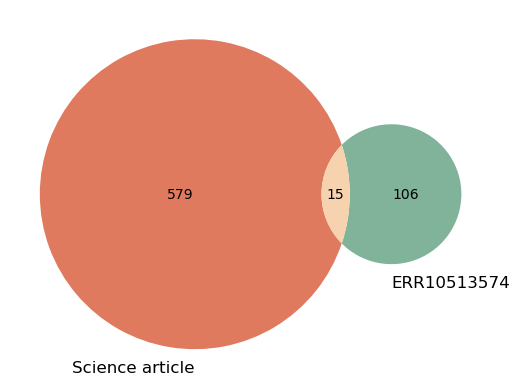

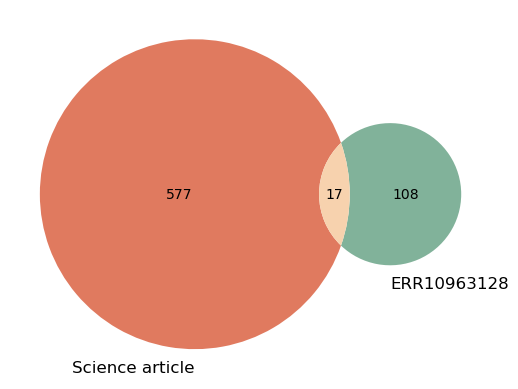

In [31]:
id_samples = ['ERR10513574', 'ERR10963128']
directory = "data/vcf/"
motif = "TC|GA"

article_pos = set(df1_new.site.tolist())
len_article_pos = len(article_pos)
print("Number of positions from the article: ", len_article_pos)
print("\n")

for sample in id_samples:
    fig, ax = plt.subplots()
    
    VCF_FILE = os.path.join(directory, sample+'_APOBEC-like.vcf')
    df = pd.read_csv(VCF_FILE, sep='\t')
    df_new = df[df.motif.str.match(motif)]
    list_positions = set(df_new.POS.tolist())
    len_list_positions = len(list_positions)
    print("Number of positions from "+sample+": ", len_list_positions)
    united_list_positions = list(list_positions) + list(article_pos)
    count_frequency = filter(lambda x: united_list_positions.count(x) > 1, united_list_positions)
    count_frequency = list(set(count_frequency))
    len_matching_positions = len(count_frequency)
    print("Number of matching positions: ", len_matching_positions)
    print("Matching positions: ", count_frequency)
    venn2([article_pos, list_positions], set_labels = ('Science article', sample), 
          set_colors=("#E07A5F", "#81B29A"),alpha=1,
          ax=ax)
    fig.savefig(os.path.join(directory, "pictures", sample+'_article_comparing.png'), dpi=800)

### Get positions with the greatest allele freq

<a name='greatest_pos'></a>
[Return to Table of Contents](#TOC)

In [ ]:
vcf_dir = "data/vcf/"
id_samples = ['ERR10513574', 'ERR10963128']
for sample in id_samples:
    VCF_FILE = os.path.join(vcf_dir, sample+'_APOBEC-like.vcf')
    OUTFILE = os.path.join(vcf_dir, sample+'_AF_positions.txt')
    
    ##read vcf file
    ##skip description in vcf file
    with open(VCF_FILE, 'r') as f:
        reader=f.readlines()
        row = 0
        while reader[row].startswith('##') == True:
            row += 1
    df_vcf = pd.read_csv(VCF_FILE, skiprows=row, sep=',')
    df_vcf = df_vcf.dropna()
    
    
    freq_list=[]
    for row in range(0, len(df_vcf)):
        FORMAT = df_vcf.loc[row, 'FORMAT'].split(':')
        AF_ind = FORMAT.index('AF')
        AF = df_vcf.loc[row, 'SAMPLE'].split(':')[AF_ind]
        freq = float(AF)
        freq_list.append(freq)
        
    df_vcf['freq'] = freq_list
    df_vcf = df_vcf.sort_values(by=['freq'], ascending=False)
    df_vcf.to_csv(OUTFILE)

1) с помощью спец программы для vcf файлов отобрать только мутации APOBEC, аннотировать их с помощью спец программы, нарисовать плот и прогнать через мою программу поиска аминокислот
2) выбрать только в подходящем контексте и сравнить с позициями из статьи